# Experimento B:

Goals:

1) Extender a classe de algum dos algoritmos no formato necessário para recomendações *user-user*.

2) Implementar o GridsSearch e validar seu uso para o nosso caso.

3) Adaptar uma varredura para diferentes quantidades de colunas acima do método do item 2.

O modelo receberá como entrar apenas o `id` da empresa e retornar uma lista do `N` mais recomendados (vizinhos mais próximos).

Verifiar: o modela terá entrada de empresas novas? Acho que não.

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [2]:
import numpy as np
import pandas as pd
from surprise import SVD, accuracy, Dataset, Reader
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from scipy.spatial.distance import cosine

from loguru import logger
from tqdm import tqdm

In [3]:
# Run this cell before close. 
%watermark
%watermark -p loguru
%watermark -p scipy
%watermark -p surprise
%watermark --iversion
%watermark -b -r -g

2020-06-21T02:00:01+00:00

CPython 3.7.7
IPython 7.15.0

compiler   : GCC 8.3.0
system     : Linux
release    : 5.4.0-7626-generic
machine    : x86_64
processor  : 
CPU cores  : 8
interpreter: 64bit
loguru 0.5.1
scipy 1.4.1
surprise 0.1
numpy  1.18.5
pandas 1.0.4

Git hash: 04793cc1dc1cc3033d56af6ea7bfb202d4d2aaa7
Git repo: https://github.com/ysraell/aceleradev_private.git
Git branch: master


In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

# Carrega e processa o dataset:

In [5]:
path_data = '../data/'
top_cols = pd.read_csv('top_cols.csv')['cols'].to_list()
df_marked = pd.read_csv(path_data+'estaticos_market.csv', usecols=top_cols)
col_user = 'id'
top_cols.remove(col_user)

rest_cols = []
for col in top_cols:
    df_marked[col] = df_marked[col].fillna(0)*1

def normalize(x):
    return (x-np.min(x))/(np.max(x) - np.min(x)) if (np.max(x) - np.min(x)) > 0 else (x-np.min(x))

escala = 100
for col in top_cols:
    df_marked[col] = (escala*normalize(df_marked[col].tolist())).astype(np.uint8)
    
remove_cols = []
for col in top_cols:
    if df_marked[col].nunique() == 1:
        remove_cols.append(col)

df_marked = df_marked.drop(columns=remove_cols)
for col in remove_cols:
    top_cols.remove(col)

df_marked = pd.melt(df_marked, id_vars=["id"], var_name="itemID", value_name="rating").rename(columns={"id": "userID"})

reader = Reader(rating_scale=(0, escala))
#data = Dataset.load_from_df(df_marked[['userID', 'itemID', 'rating']].sample(frac=0.2), reader)
data = Dataset.load_from_df(df_marked[['userID', 'itemID', 'rating']], reader)
del df_marked

# Modelo base.

In [ ]:
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.90)

In [ ]:
# We'll use the famous SVD algorithm.
algo = SVD(n_factors=10)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

In [ ]:
algo.trainset.all_users()

In [ ]:
algo.trainset.to_raw_uid(462298-1)

In [ ]:
algo.pu[4]

In [ ]:
class ExSVD(SVD):
    """
        Classe extendida da surprise.SVD.
        
    
    """
    
    def __init__(self,**args):
        self.matrix_dict = {}
        super().__init__(**args)

    def fit(self,trainset):
        """
            Reimplementei a SVD.fit para colocar um logger nível INFO.
        """
        logger.info("Treinando modelo SVD...")
        super().fit(trainset)
        logger.info("Pronto!")
    
    def get_neighbors(self,uid,k=1):
        """
            Calcula todas as distâncias entre 'uid' de entrada e todos os outros 'uid'.
            A distância calciulada é armazenda e não calculada novamente. 
        """
        logger.info("Calculando todos os vizinhos...")
        for uid2 in tqdm(self.trainset.all_users()):
            ordered = tuple(sorted((uid,uid2)))
            if (uid != uid2) and (ordered not in self.matrix_dict.keys()):
                self.matrix_dict[ordered] = cosine(self.pu[uid],self.pu[uid2])
        return [x[0] for x in sorted(
            [
                (uid2, self.matrix_dict[tuple(sorted((uid,uid2)))]) 
                for uid2 in self.trainset.all_users()
                if uid != uid2
            ], key=lambda x: x[1])][:k-1]

        

In [ ]:
# We'll use the famous SVD algorithm.
ex_algo = ExSVD(n_factors=10, verbose=True)

# Train the algorithm on the trainset, and predict ratings for the testset
ex_algo.fit(trainset)
predictions = ex_algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

Dado o `uid` (*o id de usuário no modelo*), retorna uma lista dos `uid`s mais próximos (`List[uid]`).

In [ ]:
ex_algo.get_neighbors(4,10)

**Item 1 completo.**

In [6]:
param_grid = {
    'n_factors': [x for x in range(100,220,5)]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=4, n_jobs=1, joblib_verbose=4)
logger.info("Running GS...")
gs.fit(data)
logger.info("...pronto!")

2020-06-21 02:00:21.011 | INFO     | __main__:<module>:6 - Running GS...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 313.1min finished
2020-06-21 07:14:39.166 | INFO     | __main__:<module>:8 - ...pronto!


In [7]:
# best RMSE score
print(gs.best_params['mae'])
print(gs.best_score['mae'])
print(gs.best_params['rmse'])
print(gs.best_score['rmse'])

{'n_factors': 210}
9.154346428374495
{'n_factors': 170}
18.069024999023156


In [8]:
results_df = pd.DataFrame.from_dict(gs.cv_results)

In [9]:
results_df.to_csv('results_000.csv')

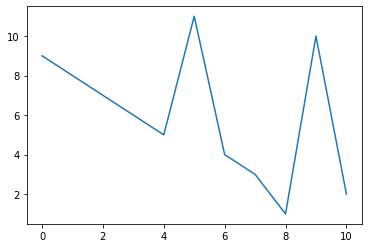

In [13]:
results_df.sort_values(by='param_n_factors').rank_test_rmse.plot()

In [14]:
313/60

5.216666666666667

In [18]:
313/len(([x for x in range(10,220,20)]))

28.454545454545453

In [21]:
28.5 * len([x for x in range(100,220,5)])/60

11.4